In [12]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as crs
import pandas as pd
import cftime
import re
import os
import sys

In [13]:
import intake

In [34]:
pwd

'/home/k/k206175/QuanLiu/SummerSchool_FlatEarth-1'

In [32]:
cd ../

/home/k/k206175/QuanLiu/SummerSchool_FlatEarth-1


In [35]:
cd pyicon_easyms22

/home/k/k206175/QuanLiu/SummerSchool_FlatEarth-1/pyicon_easyms22


In [36]:
import pyicon as pyic

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----accessor
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----accessor
-----view
-----quickplots
-----quickplots


In [14]:
# some utilities


def find_grids(dataset):
    """ Generic ICON Grid locator
    
    This function checks an xarray dataset for attributes that contain "grid_file_uri", and checks if it can map them to a local path.
    It also checks for "grid_file_name"
    
    It returns a list of paths on disk that are readable (os.access(x, os.R_OK)).
    """
    uris = [ dataset.attrs[x] for x in dataset.attrs if "grid_file_uri" in x] # this thing might come in one of various names...
    search_paths = [ re.sub('http://icon-downloads.mpimet.mpg.de', '/pool/data/ICON', x) for x in uris ] + [os.path.basename(x) for x in uris] # plausible mappings on mistral.
    if "grid_file_path" in dataset.attrs:
        search_paths.append(dataset.attrs["grid_file_path"])
        search_paths.append(os.path.basename(dataset.attrs["grid_file_path"])) # also check the current dir.
    paths = [ x for x in search_paths if ( os.access(x, os.R_OK) ) ] # remove things that don't exist.
    if not paths:
        message = "Could not determine grid file!"
        if search_paths :
            message = message + "\nI looked in\n"+"\n".join(search_paths)
        if uris:
            message = message + ("\nPlease check %s for a possible grid file"%(" or ").join(uris))
        raise Exception (message)
    if len (set(paths) ) > 1:
        print ("Found multiple conflicting grid files. Using the first one.", file=sys.stderr)
        print ("Files found:", file=sys.stderr)
        print ("\n".join(paths), file=sys.stderr)
    return paths


def add_grid (dataset):
    """Generic icon grid adder.
    
    Calls find_grids to locate a grid file, and - if it finds one - adds this grid file to a Dataset.
    
    also tries to ensure that clon has the same dimensions as the data variables.
    """
    paths = find_grids (dataset)
    grid = xr.open_dataset(paths[0])
    rename = {} # icon uses different dimension names in the output than in the grid file. (whyever...)
    if "ncells" in dataset.dims:
        grid_ncells = grid.clon.dims[0]
        rename = {grid_ncells : "ncells"}
    drops = set([ x for x in grid.coords if x in dataset.data_vars or x in dataset.coords ] + [ x for x in grid.data_vars if x in dataset.data_vars or x in dataset.coords ])
    return xr.merge((dataset.drop(drops), grid.rename(rename)))

def get_tripcolor_grid_args (ds):
    """Returns the grid arguments for tripcolor"""
    return np.rad2deg(ds.vlon), np.rad2deg(ds.vlat), ds.vertex_of_cell.T.values -1

#for x in cat_dict.keys():
#    data = add_grid(cat_dict[x])


def get_from_cat(col, name, searchdict):
    """Performs a search as specified in catdict on an intake-xarray collection/catalog and returns the unique keys of category 'name' """
    cat = col.search(**searchdict)
    return sorted(cat.unique(name)[name]['values'])


def filter_filename(cat, string):
    matches = [x for x in cat.unique("filename")['filename']['values'] if string in x]
    return cat.search(filename=matches ) 

# read data

In [22]:
catalog_file = '/home/k/k206175/icon-easyms/experiments/sus22F2/scripts/sus22F2.json'

In [23]:
cat = intake.open_esm_datastore(catalog_file)

In [24]:
cat

,unique
variable_id,450
project,1
institution_id,1
source_id,1
experiment_id,1
simulation_id,1
realm,2
frequency,2
time_reduction,2
grid_label,1


In [25]:
cat.df.head()

,variable_id,project,institution_id,source_id,experiment_id,simulation_id,realm,frequency,time_reduction,grid_label,level_type,time_min,time_max,grid_id,format,uri
0,"(tas_gmean, rsdt_gmean, rsut_gmean, rlut_gmean...",private,MPI-M,ICON-ESM,esmControl,sus22F2,atm,1month,mean,gn,ml,1850-01-31T23:45:00.000,1859-12-31T23:45:00.000,not implemented,netcdf,/work/mh1049/k206175/icon-easyms/experiments/s...
1,"(tas_gmean, rsdt_gmean, rsut_gmean, rlut_gmean...",private,MPI-M,ICON-ESM,esmControl,sus22F2,atm,1month,mean,gn,ml,1860-01-31T23:45:00.000,1869-12-31T23:45:00.000,not implemented,netcdf,/work/mh1049/k206175/icon-easyms/experiments/s...
2,"(tas_gmean, rsdt_gmean, rsut_gmean, rlut_gmean...",private,MPI-M,ICON-ESM,esmControl,sus22F2,atm,1month,mean,gn,ml,1870-01-31T23:45:00.000,1879-12-31T23:45:00.000,not implemented,netcdf,/work/mh1049/k206175/icon-easyms/experiments/s...
3,"(tas_gmean, rsdt_gmean, rsut_gmean, rlut_gmean...",private,MPI-M,ICON-ESM,esmControl,sus22F2,atm,1month,mean,gn,ml,1880-01-31T23:45:00.000,1889-12-31T23:45:00.000,not implemented,netcdf,/work/mh1049/k206175/icon-easyms/experiments/s...
4,"(tas_gmean, rsdt_gmean, rsut_gmean, rlut_gmean...",private,MPI-M,ICON-ESM,esmControl,sus22F2,atm,1month,mean,gn,ml,1890-01-31T23:45:00.000,1899-12-31T23:45:00.000,not implemented,netcdf,/work/mh1049/k206175/icon-easyms/experiments/s...


In [26]:


var = 'rsdt'
rsdt = cat.search(variable_id = var)

In [27]:
rsdt

,unique
variable_id,44
project,1
institution_id,1
source_id,1
experiment_id,1
simulation_id,1
realm,1
frequency,1
time_reduction,1
grid_label,1


In [28]:
cat_dict = rsdt.to_dataset_dict(cdf_kwargs = {"use_cftime" : True, 'chunks': {'time': 120}}) # cdf_kwargs={'chunks': {'time': 1,}}
cat_dict


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.simulation_id.realm.frequency.time_reduction.grid_label.level_type'


{'private.MPI-M.ICON-ESM.esmControl.sus22F2.atm.1month.mean.gn.2d': <xarray.Dataset>
 Dimensions:  (time: 6000, ncells: 5120)
 Coordinates:
   * time     (time) object 1850-01-31 23:45:00 ... 2349-12-31 23:45:00
 Dimensions without coordinates: ncells
 Data variables:
     rsdt     (time, ncells) float32 dask.array<chunksize=(120, 5120), meta=np.ndarray>
 Attributes: (12/14)
     Conventions:             CF-1.6
     references:              see MPIM/DWD publications
     title:                   ICON simulation
     grid_file_uri:           http://icon-downloads.mpimet.mpg.de/grids/public...
     history:                 Fri Sep 16 15:20:06 2022: cdo -r -O -z zip -shif...
     intake_esm_varname:      ['rsdt']
     ...                      ...
     comment:                 v175 Workshop (k206175) on l20009 (Linux 4.18.0-...
     number_of_grid_used:     30
     CDO:                     Climate Data Operators version 2.0.5 (https://mp...
     source:                  git@gitlab.dkrz.de:

In [40]:
cat_dict.keys()

dict_keys(['private.MPI-M.ICON-ESM.esmControl.sus22F2.atm.1month.mean.gn.2d'])

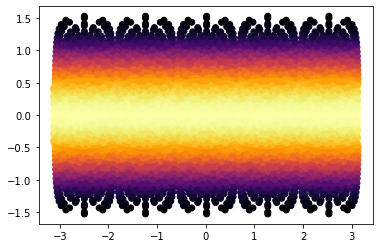

In [43]:
for x in cat_dict.keys():
    cat_dict[x] = add_grid(cat_dict[x])
    data = cat_dict[x].mean(dim="time")
    plt.figure()
    plt.scatter(data.clon, data.clat, c=data[var], cmap='inferno') 

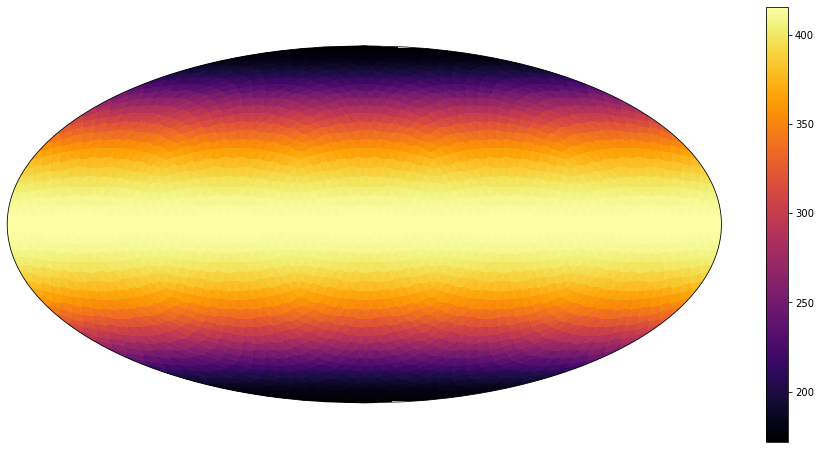

In [47]:
def map_plot (data, var=None, grid=None, method="scatter", projection=crs.Mollweide(), filename = "", size=100,  **kwargs):
    fig = plt.figure (figsize=(16,8))
    ax = fig.add_subplot(1,1,1, projection=projection) # Mollweide
    ax.set_global()
    plotdata = data
    if type (data) == xr.Dataset:
        plotdata = plotdata[var]
    plotdata = plotdata.squeeze()
    if grid is None:
        grid = data
    if method == "tripcolor":
        x, y, tri = get_tripcolor_grid_args(grid)
        plt.tripcolor(x, y, tri, plotdata, transform=crs.Geodetic(), **kwargs)
    elif method == "scatter":
        plt.scatter(np.rad2deg(grid.clon), np.rad2deg(grid.clat), c=plotdata, transform=crs.Geodetic(), s=size, **kwargs)
    cb = plt.colorbar()
    plt.savefig(filename)
    return (fig)

for x, data in cat_dict.items():
    map_plot(data.mean(dim="time"), var, grid=data, cmap="inferno", method='tripcolor')


In [2]:
def CESM_heat_transport(ncdata):
    lat = ncdata.variables['lat'][:]
    # TOA radiation
    OLR = np.mean(ncdata.variables['FLNT'][:], axis=2)
    ASR = np.mean(ncdata.variables['FSNT'][:], axis=2)
    Rtoa = ASR - OLR  # net downwelling radiation
    #  surface fluxes  (all positive UP)
    LHF = np.mean(ncdata.variables['LHFLX'][:], axis=2)  # latent heat flux (evaporation)
    SHF = np.mean(ncdata.variables['SHFLX'][:], axis=2) # sensible heat flux
    LWsfc = np.mean(ncdata.variables['FLNS'][:], axis=2)  # net longwave radiation at surface
    SWsfc = -np.mean(ncdata.variables['FSNS'][:], axis=2)  # net shortwave radiation at surface
    #  energy flux due to snowfall
    SnowFlux =  np.mean(ncdata.variables['PRECSC'][:]+
                        ncdata.variables['PRECSL'][:], axis=2)*const.rho_w*const.Lhfus
    #  hydrological cycle
    Evap = np.mean(ncdata.variables['QFLX'][:], axis=2)  # kg/m2/s or mm/s
    Precip = np.mean(ncdata.variables['PRECC'][:]+
                    ncdata.variables['PRECL'][:], axis=2)*const.rho_w  # kg/m2/s or mm/s
    EminusP = Evap - Precip  # kg/m2/s or mm/s
    SurfaceRadiation = LWsfc + SWsfc  # net upward radiation from surface
    SurfaceHeatFlux = SurfaceRadiation + LHF + SHF + SnowFlux  # net upward surface heat flux
    Fatmin = Rtoa + SurfaceHeatFlux  # net heat flux in to atmosphere
    # heat transport terms
    HTmonthly = {}
    HTmonthly['total'] = inferred_heat_transport(Rtoa, lat)
    HTmonthly['atm'] = inferred_heat_transport(Fatmin, lat)
    HTmonthly['ocean'] = inferred_heat_transport(-SurfaceHeatFlux, lat)
    HTmonthly['latent'] = inferred_heat_transport(EminusP*const.Lhvap, lat) # atm. latent heat transport from moisture imbal.
    HTmonthly['dse'] = HTmonthly['atm'] - HTmonthly['latent']  # dry static energy transport as residual

    #  annual averages
    HTann = {}
    for name, value in HTmonthly.iteritems():
        HTann[name] = np.mean(value, axis=0)
        
    return HTann, HTmonthly

In [48]:
ex = xr.open_dataset("/work/mh1049/k206175/icon-easyms/experiments/sus22F2/outdata/sus22F2_oce_P1M_2d_22900101.nc")

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [74]:
ex

<xarray.Dataset>
Dimensions:                          (time: 120, ncells: 15105, vertices: 3,
                                      ncells_2: 23207, vertices_2: 4, depth: 1,
                                      lev: 1)
Coordinates:
  * time                             (time) object 2290-01-31 23:00:00 ... 22...
    clon                             (ncells) float32 1.206 1.274 ... 1.327
    clat                             (ncells) float32 1.27 1.301 ... -0.7828
    elon                             (ncells_2) float32 1.241 1.343 ... 1.327
    elat                             (ncells_2) float32 1.263 1.278 ... -0.7948
  * depth                            (depth) float64 6.0
  * lev                              (lev) float64 0.0
Dimensions without coordinates: ncells, vertices, ncells_2, vertices_2
Data variables: (12/53)
    clon_bnds                        (ncells, vertices) float32 1.274 ... 1.354
    clat_bnds                        (ncells, vertices) float32 1.279 ... -0.794
    elon_bnds                        (ncells_2, vertices_2) float32 0.0 ... 0.0
    elat_bnds                        (ncells_2, vertices_2) float32 1.279 ......
    to                               (time, depth, ncells) float32 ...
    so                               (time, depth, ncells) float32 ...
    ...                               ...
    FrshFlux_TotalOcean              (time, ncells) float32 ...
    FrshFlux_VolumeIce               (time, ncells) float32 ...
    totalsnowfall                    (time, ncells) float32 ...
    FrshFlux_VolumeTotal             (time, ncells) float32 ...
    swsum                            (time, ncells) float32 ...
    heatabs                          (time, ncells) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 2.0.5 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  36
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          5bd948e8-ac1a-11ea-a6b1-d317264fdca9
    source:               git@gitlab.dkrz.de:icon/icon-les.git@4ea9f3495f36d1...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    history:              Mon Sep 19 20:05:24 2022: cdo -r -O -z zip -shiftti...
    references:           see MPIM/DWD publications
    comment:              v175 Workshop (k206175) on l40293 (Linux 4.18.0-305...
    CDO:                  Climate Data Operators version 2.0.5 (https://mpime...

In [ ]:
ex.

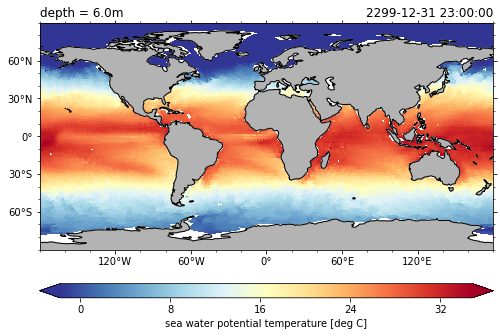

In [73]:
ex.to.isel(time=-1,depth=0).pyic.plot()

In [72]:
ds = ex.atmos_fluxes_HeatFlux_Total

TypeError: unhashable type: 'DataArray'

In [81]:
a = ex.atmos_fluxes_HeatFlux_Total.to_dataset()

In [82]:
a

<xarray.Dataset>
Dimensions:                      (time: 120, ncells: 15105)
Coordinates:
  * time                         (time) object 2290-01-31 23:00:00 ... 2299-1...
    clon                         (ncells) float32 1.206 1.274 ... 1.302 1.327
    clat                         (ncells) float32 1.27 1.301 ... -0.8173 -0.7828
Dimensions without coordinates: ncells
Data variables:
    atmos_fluxes_HeatFlux_Total  (time, ncells) float32 ...

In [83]:
a.attrs = ex.attrs

In [84]:
a

<xarray.Dataset>
Dimensions:                      (time: 120, ncells: 15105)
Coordinates:
  * time                         (time) object 2290-01-31 23:00:00 ... 2299-1...
    clon                         (ncells) float32 1.206 1.274 ... 1.302 1.327
    clat                         (ncells) float32 1.27 1.301 ... -0.8173 -0.7828
Dimensions without coordinates: ncells
Data variables:
    atmos_fluxes_HeatFlux_Total  (time, ncells) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 2.0.5 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  36
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          5bd948e8-ac1a-11ea-a6b1-d317264fdca9
    source:               git@gitlab.dkrz.de:icon/icon-les.git@4ea9f3495f36d1...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    history:              Mon Sep 19 20:05:24 2022: cdo -r -O -z zip -shiftti...
    references:           see MPIM/DWD publications
    comment:              v175 Workshop (k206175) on l40293 (Linux 4.18.0-305...
    CDO:                  Climate Data Operators version 2.0.5 (https://mpime...

In [57]:
ds = ex['atmos_fluxes_HeatFlux_Total'].to_dataset()

In [58]:
ds

<xarray.Dataset>
Dimensions:                      (time: 120, ncells: 15105)
Coordinates:
  * time                         (time) object 2290-01-31 23:00:00 ... 2299-1...
    clon                         (ncells) float32 1.206 1.274 ... 1.302 1.327
    clat                         (ncells) float32 1.27 1.301 ... -0.8173 -0.7828
Dimensions without coordinates: ncells
Data variables:
    atmos_fluxes_HeatFlux_Total  (time, ncells) float32 ...

In [62]:
ds.attrs = ex.attrs

In [63]:
ds.to.isel(time=-1,depth=0).pyic.plot()

AttributeError: 'Dataset' object has no attribute 'to'